In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
import epifit2
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"



In [12]:
def sim(timeHorizon, model:epifit2.get_ER_random_contact):
  populationNumber= []
  populationExpectation= []
  for i in range(timeHorizon):
    populationNumberi, populationExpectationi= model()
    populationNumber.append(populationNumberi)
    populationExpectation.append(populationExpectationi)
  populationNumber = torch.stack(populationNumber)
  populationExpectation = torch.stack(populationExpectation)

  return populationNumber, populationExpectation

In [16]:
n= 8000
avgDegree= 10
timeHorizon= 40
print("haha")
contact=epifit2.get_ER_random_contact(n, avgDegree)
print("haha")
contact = contact.requires_grad_(True)
realData =None
with torch.no_grad():
    ps= torch.tensor([[0, 0.2, 0, 0],
                    [0, 0, 0.8, 0],
                    [0, 0, 0, 0.1],
                    [0.01, 0, 0, 0]], device=device)
    population= epifit2.population(n, device)
    model= epifit2.EPI_dense(contact, ps, population, device)
    realData, _ =sim(timeHorizon, model)


haha
haha


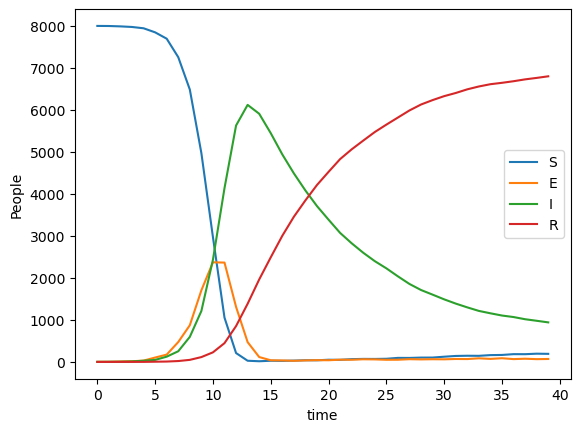

In [17]:
populationNumberPlot= realData.cpu().detach()
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("People")
plt.legend()

In [18]:
realData.requires_grad_(True)
psFit= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
cc= torch.tensor([[0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [1, 0, 0, 0]], device=device)
populationFit= epifit2.population(n, device)
modelFit= epifit2.EPI_dense(contact, psFit, populationFit, device, train=True, cc=cc, recursive=True)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=3e-1)

In [19]:
fitPinfs=[]
#1. choose a better optimiser
#2. bigmodel learn intrinsic, gradient easy model !!!
#3. adaptive constraint?
#4. GAN ?
losses= []
for i in tqdm(range(500)):
    optimizer.zero_grad()
    fitPinfs.append(modelFit.get_psMatrix())
    populationFit= epifit2.population(n, device)
    modelFit.reset_population(populationFit)
    fitPopulation, expectation = sim(timeHorizon, modelFit)
    #loss= lossFn(expectation, realData)/n/timeHorizon
    loss= lossFn(expectation[:, 2], realData[:, 2])/n/timeHorizon
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
print(modelFit.get_psMatrix())

100%|██████████| 500/500 [03:10<00:00,  2.63it/s]

tensor([[0.0000, 0.1816, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7155, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0971],
        [0.0079, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)


tensor([[0.0000, 0.1816, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7155, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0971],
        [0.0079, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)


Text(0, 0.5, 'loss')

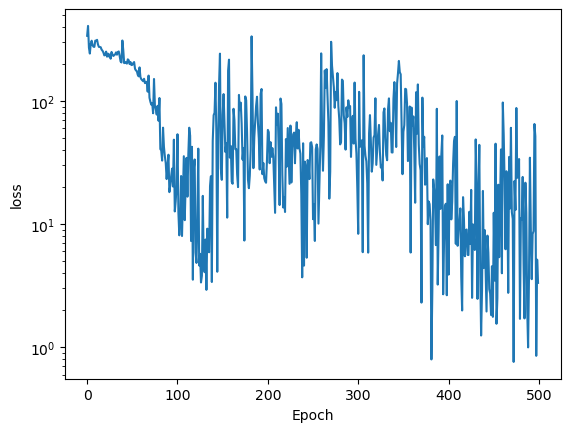

In [20]:
print(modelFit.get_psMatrix())
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("loss")

In [21]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.2035, -0.2035,  0.2035,  0.2035],
        [-1.0104, -1.0104,  1.0104, -1.0104],
        [ 0.5655,  0.5655,  0.5655, -0.5655],
        [-1.8690,  1.8690,  1.8690,  1.8690]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[-3.2384e-01,  9.7153e-01, -3.2384e-01, -3.2384e-01],
        [-1.7275e+00, -1.7275e+00,  5.1824e+00, -1.7275e+00],
        [-2.2142e-01, -2.2142e-01, -2.2142e-01,  6.6426e-01],
        [ 2.2175e-03, -7.3918e-04, -7.3918e-04, -7.3918e-04]], device='cuda:0')
---------------------------------


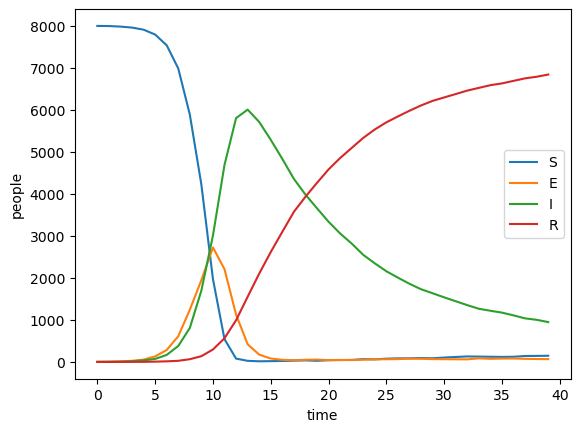

In [22]:
populationNumberPlot2= fitPopulation.cpu().detach()
plt.plot(populationNumberPlot2, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("people")
plt.legend()